# <center> cs231. Assignment 2.

Goal is to build convolutional neural network with linear layers to work on CIFAR-10 dataset and reach at least $70\%$ accuracy on test set. This is a part where I use PyTorch for this.

## Importing libs

Load all the necessary libs, including my scripts for training and visualizations.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
import os
import glob
import pickle

import gc

import copy

# ================================================

if not '..' in sys.path:
    sys.path = ['..'] + sys.path

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from _cs231n.torch_utils import *
from _cs231n.metrics import accuracy, confusion_matrix

# ================================================

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# ================================================

PATH_TO_DATA = '../data/cifar-10-batches-py'

## Loading & visualizing dataset

Dataset has been previously downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). There is a script `get_data.sh` in `assignment1` folder for this. Dataset is already split into train and test.

We will also normalize dataset on each of 3 channels separately to zero mean and unit variance.

In [2]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0)
X_train0 = X_train0.reshape(-1, 3, 32, 32)
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data']
    X_test0 = X_test0.reshape(-1, 3, 32, 32)
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================
# Load images categories

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]
    
# ================================================
# Normalize dataset separately on each channel
    
X_mean = (X_train0.astype(np.float64)/255).mean(axis=(0, 2, 3))
X_std = (X_train0.astype(np.float64)/255).std(axis=(0, 2, 3))

X_train_norm = ((X_train0.astype(np.float64)/255) - X_mean[None, :, None, None])/X_std[None, :, None, None]
X_test_norm = ((X_train0.astype(np.float64)/255) - X_mean[None, :, None, None])/X_std[None, :, None, None]

Training data shape: 50000x3
Test data shape: 10000x3


Let's visualize dataset to see what we're dealing with. There are 10 categories of images, we will display several pics from each category.

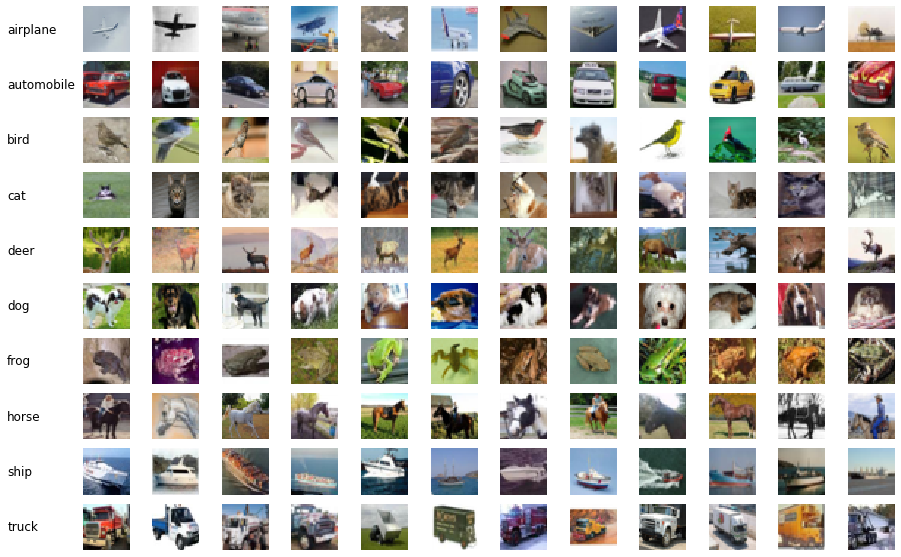

In [3]:
n_imgs = 12
labels = np.unique(y_train0)

fig0, axs = plt.subplots(nrows=len(labels), ncols=n_imgs + 1, figsize=(16, len(labels)))
for (xlabel, xcat, xaxs) in zip(labels, categories, axs):
    xaxs[0].text(0, 0.5, xcat, fontsize=12, va='center')
    xaxs[0].axis('off')
    idxs = np.random.choice(np.argwhere(y_train0 == xlabel).ravel(), n_imgs, replace=False)
    
    for (idx, xax) in zip(idxs, xaxs[1:]):
        xax.imshow(X_train0[idx].transpose((1, 2, 0)))
        xax.set_aspect('equal')
        xax.axis('off')

Ok, due to low resolution some pics are pretty hard to get, even for human eye. Hope that neural net will do better than me.

As usual, we pick some data randomly from training set to serve as validation data.

In [4]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## Setting up PyTorch

I will use my GPU to work on this project.

In [5]:
assert torch.cuda.is_available()
GPU = torch.device('cuda: 0')

Although we're working with images here - we won't be using any image-specific tools and data augmentations, so simple `TensorDataset` would be enough. One note: Torch prefers images to have dimensions as ($B$, $C$, $H$, $W$), so we need to transpose axes a little.

In [6]:
X_train_norm_torch = torch.from_numpy(X_train_norm.transpose((0, 3, 1, 2))).type(torch.float)
y_train_torch = torch.from_numpy(y_train0).type(torch.LongTensor)
X_test_norm_torch = torch.from_numpy(X_test_norm.transpose((0, 3, 1, 2))).type(torch.float)
y_test_torch = torch.from_numpy(np.array(y_test0)).type(torch.LongTensor)

tiny_dset = TensorDataset(X_train_norm_torch[train_idxs[:100]], y_train_torch[train_idxs[:100]])
train_dset = TensorDataset(X_train_norm_torch[train_idxs], y_train_torch[train_idxs])
val_dset = TensorDataset(X_train_norm_torch[val_idxs], y_train_torch[val_idxs])
test_dset = TensorDataset(X_test_norm_torch, y_test_torch)

AssertionError: 

Prepare data loaders.

In [7]:
train_loader = DataLoader(train_dset, batch_size=128, 
                          sampler=RandomSampler(train_dset))
val_loader = DataLoader(val_dset, batch_size=128, 
                        sampler=RandomSampler(val_dset))
test_loader = DataLoader(test_dset, batch_size=128, 
                         sampler=SequentialSampler(test_dset))

NameError: name 'test_dset' is not defined

Helper class that we use to pass from convolutional layers to fully-connected. All it does is just flattening tensor into 2 dimensions: batch and features.

In [8]:
class Flattener(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X.view(X.shape[0], -1)

## Training torch models

Here we build and test several models, trying to reach our goal - get $70\%$ accuracy on test dataset.

### Torch model 1.

As usual, first model is very simple. Just one 3x3 convolution followed by max pooling, and then we flatten and pass it to two-layers linear classificator. Also, BatchNorms and Dropouts are added to reduce overfitting.

In [18]:
model_torch1 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), 
    # 32 x 32 x 32
    nn.MaxPool2d(kernel_size=5, stride=3), 
    # 32 x 10 x 10
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=32), 
    nn.Dropout(p=0.2), 
    Flattener(), 
    # 3200
    nn.Linear(in_features=3200, out_features=512, bias=False), 
    # 512
    nn.BatchNorm1d(num_features=512), 
    nn.Dropout(p=0.5),
    nn.ReLU(), 
    nn.Linear(in_features=512, out_features=10)
    # 10
)

Moving model to GPU.

In [150]:
model_torch1.type(torch.cuda.FloatTensor)
model_torch1.to(GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Flattener()
  (6): Linear(in_features=3200, out_features=512, bias=False)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=10, bias=True)
)

#### Training

Let's check how model initializes. We expect to see accuracy of around $10\%$ and log-loss of around $\log{10} \approx 2.30$.

In [151]:
init_check = initial_model_check(model_torch1, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss = [init_check[0]]
val_loss = [init_check[1]]
val_acc = [init_check[2]]

Model loss on train set: 2.303
Model loss on validation set: 2.302
Model metric on validation set set: 0.10264


Very good.

I intentionally skip overfitting to small dataset here. It does overfit though, I tried it.

All right. Initialize all the necessary components: loss function, optimizer and learning rate scheduler and get on with training. We will train for 24 epochs, gradually decreasing learning rate.

In [27]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch1.parameters(), lr=1e-2, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.95, step_size=3)

# tr_res = train_torch(model_torch1, GPU, train_loader, val_loader, 
#                      loss_fct, opt, lr_sch, accuracy, 
#                      num_epochs=24, verbose=True, show_progress=True, 
#                      early_stopping=True, early_stopping_rounds=3, 
#                      delay=0)

# tr_loss += tr_res[0]
# val_loss += tr_res[1]
# val_acc += tr_res[2]

The results are significantly better than with fully connected layers only. Even the simplest model got us to $70\%$ accuracy on validation, even if only by a tiny margin. Fantastic.

Let's see the training history.

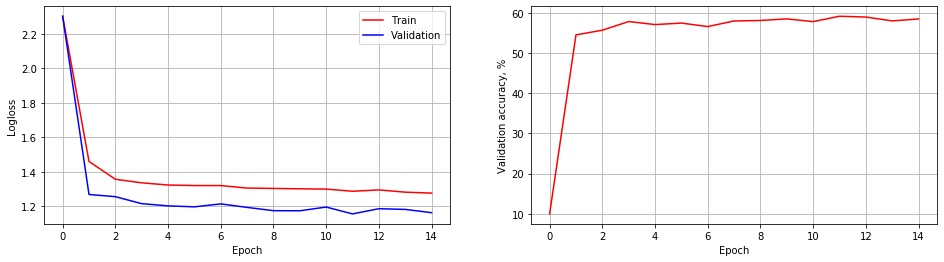

In [147]:
visualize_training(tr_loss, val_loss, val_acc)

The curves look very good - I see no ovefitting, and we got above $70\%$ accuracy on validation set.

#### Saving/loading model

In [87]:
#torch.save(model_torch1.state_dict(), os.path.join('.', 'model_torch1_weights'))
model_torch1.load_state_dict(torch.load(os.path.join('.', 'model_torch1_weights')))

FileNotFoundError: [Errno 2] No such file or directory: './model_torch1_weights'

#### Performance analysis

Let's analyze our model performance a little. Accuracy is very intuitive, but unfortunately not very informative metric. It takes into account only hard predictions (class with largest probability), but what if out model is not sure of its prediction? Let's see how probability of selected class is distributed depending on whether our model is correct or not. And also see how it performs on test dataset.

Test set accuracy: 59.256%


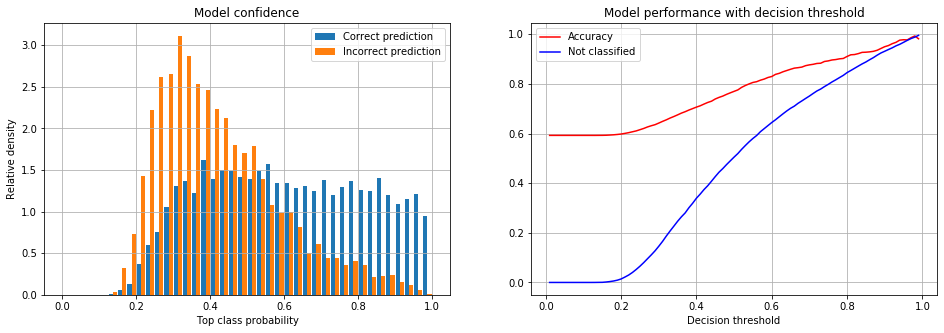

In [153]:
predX, gt, _ = predict_torch(model_torch1, val_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.3f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

Aha. So, our model tends to be pretty sure when it is correct, and not so sure when it is wrong. Second graph shows how our accuracy increases when we employ desicion threshold - we take no decision if largest class probability is below certain number.

Let's see where our model is wrong the most.

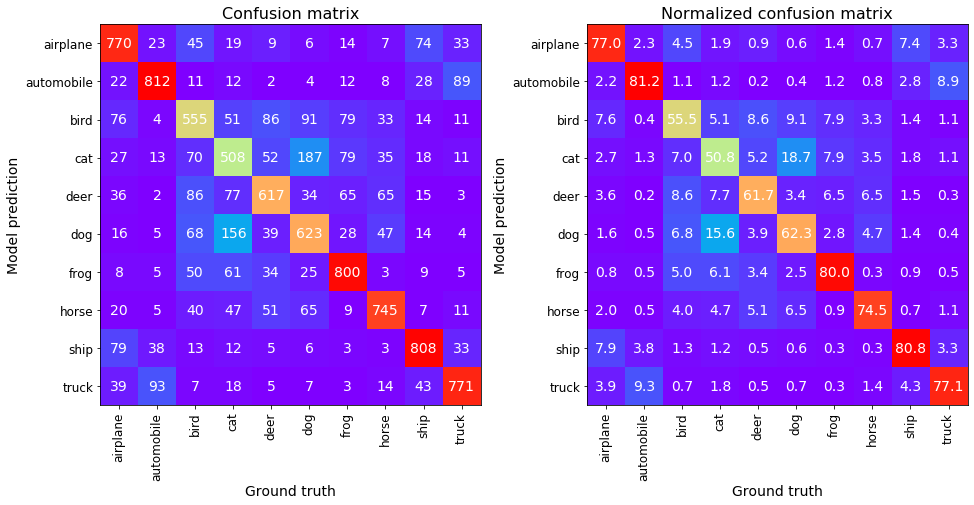

In [15]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

So, most confused classes are `cat` and `dog`, and also `bird` and `deer` are among least correctly classified classes. How do these incorrect predictions might look?

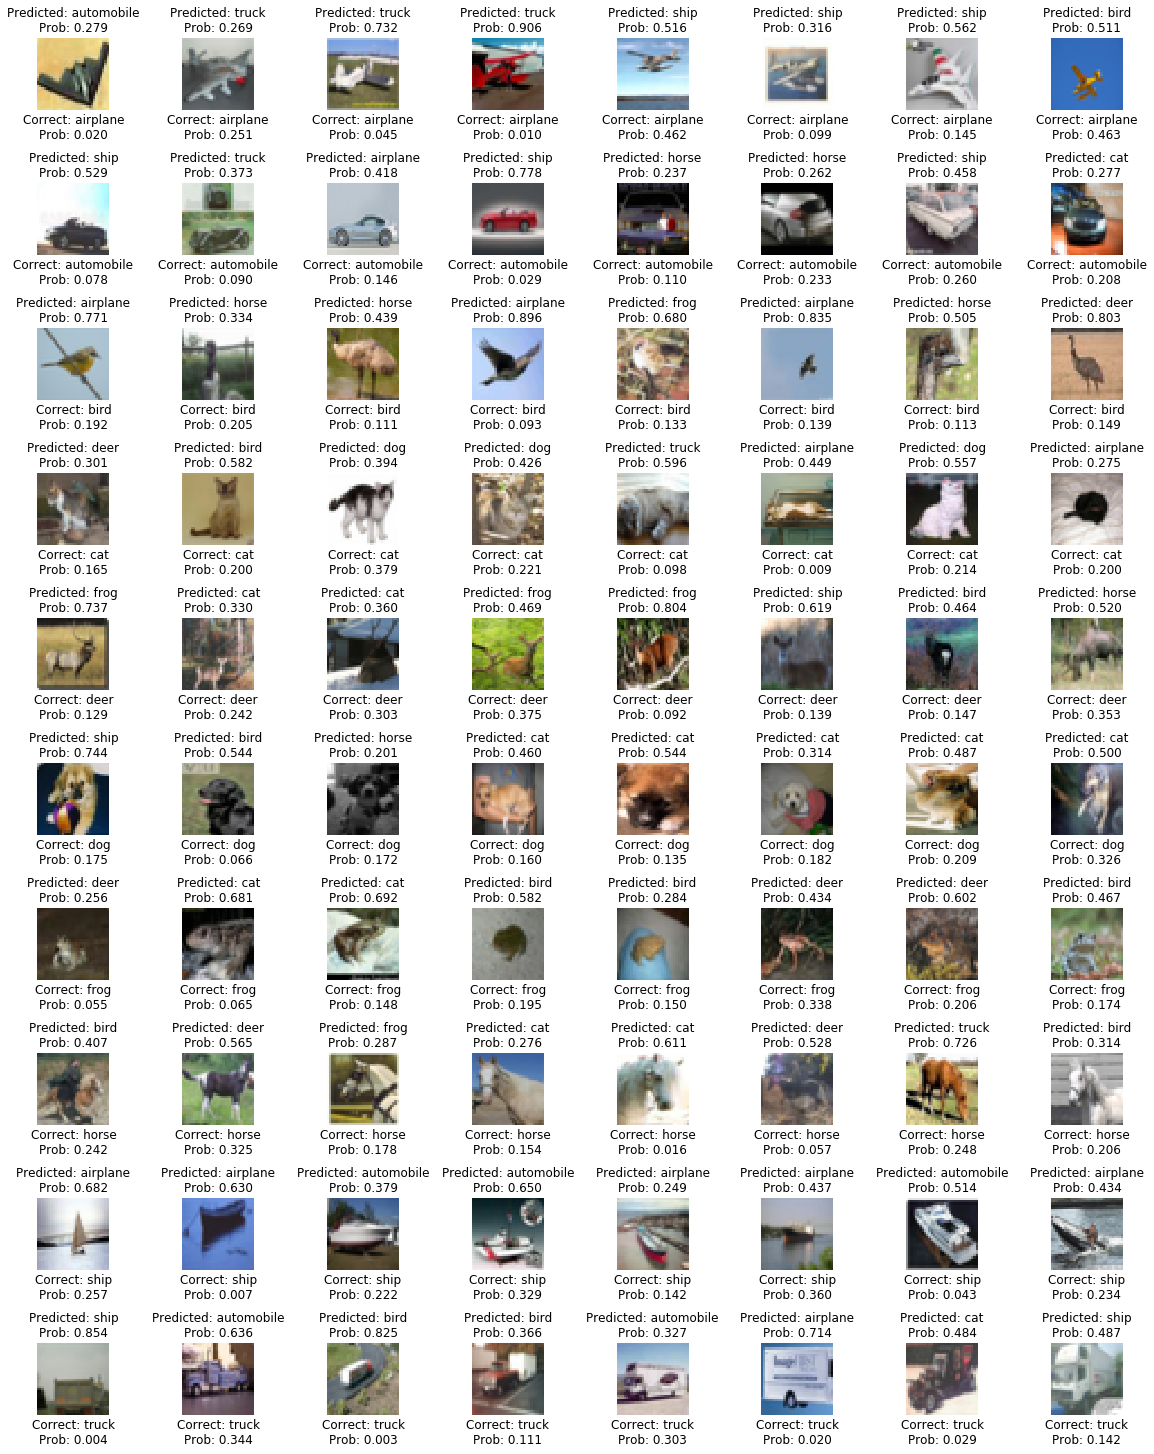

In [16]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 2.

Ok, our simple model performed quite well, but let's complicate things a little. Add one more convolution layer and increase number of channels.

In [17]:
model_torch2 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=0), 
    # 64 x 28 x 28
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 64 x 14 x 14
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=64), 
    nn.Dropout(p=0.2), 
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0), 
    # 128 x 10 x 10
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 128 x 5 x 5
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=48), 
    nn.Dropout(p=0.2), 
    nn.AvgPool2d(kernel_size=5), 
    # 128 x 1 x 1
    Flattener(), 
    # 128
    nn.Linear(in_features=128, out_features=32, bias=False), 
    # 32
    nn.ReLU(), 
    nn.BatchNorm1d(num_features=32), 
    nn.Dropout(p=0.5), 
    nn.Linear(in_features=32, out_features=10)
    # 10
)

Moving model to GPU.

In [18]:
model_torch2.type(torch.cuda.FloatTensor)
model_torch2.to(GPU)

Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Conv2d(12, 48, kernel_size=(5, 5), stride=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): ReLU()
  (8): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.2)
  (10): Flattener()
  (11): Linear(in_features=1200, out_features=128, bias=False)
  (12): ReLU()
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.5)
  (15): Linear(in_features=128, out_features=10, bias=True)
)

#### Training

Let's check how PyTorch model initializes.

In [156]:
init_check = initial_model_check(model_torch2, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss[2] = [init_check[0]]
val_loss[2] = [init_check[1]]
val_acc[2] = [init_check[2]]

Model loss on train set: 2.304
Model loss on validation set: 2.304
Model metric on validation set set: 0.10768


Indeed I have to revisit my initialization strategy. This one is close to perfect.

All right. Initialize all the necessary components and get on with training. We will train for 40 epochs.

In [157]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch2.parameters(), lr=1e-3, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.8, step_size=3)

tr_res = train_torch(model_torch2, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     delay=5)

tr_loss[2] += tr_res[0]
val_loss[2] += tr_res[1]
val_acc[2] += tr_res[2]

--------------------------------
Epoch 1/24
--------------------------------


Training pass over. Loss: 1.5504534095001221
Validation loss: 1.2586786320114136
Validation metric: 0.55248


Delay for 5 seconds
--------------------------------
Epoch 2/24
--------------------------------


Training pass over. Loss: 1.2333797812016805
Validation loss: 1.126567350883484
Validation metric: 0.59928


Delay for 5 seconds
--------------------------------
Epoch 3/24
--------------------------------


Training pass over. Loss: 1.1252999236297607
Validation loss: 1.024337389602661
Validation metric: 0.63728


Delay for 5 seconds
--------------------------------
Epoch 4/24
--------------------------------


Training pass over. Loss: 1.0428509455362955
Validation loss: 0.9746253942871094
Validation metric: 0.6496


Delay for 5 seconds
--------------------------------
Epoch 5/24
--------------------------------


Training pass over. Loss: 0.99253398630778
Validation loss: 0.9413100664520264
Validation metric: 0.66512


Delay for 5 seconds
--------------------------------
Epoch 6/24
--------------------------------


Training pass over. Loss: 0.9637285327657064
Validation loss: 0.9058973253059387
Validation metric: 0.67744


Delay for 5 seconds
--------------------------------
Epoch 7/24
--------------------------------


Training pass over. Loss: 0.9221178667640686
Validation loss: 0.8804474586486817
Validation metric: 0.6892


Delay for 5 seconds
--------------------------------
Epoch 8/24
--------------------------------


Training pass over. Loss: 0.9003557831128438
Validation loss: 0.8718615753746033
Validation metric: 0.6932


Delay for 5 seconds
--------------------------------
Epoch 9/24
--------------------------------


Training pass over. Loss: 0.8837044904009501
Validation loss: 0.8490509355354309
Validation metric: 0.70088


Delay for 5 seconds
--------------------------------
Epoch 10/24
--------------------------------


Training pass over. Loss: 0.8496408050664266
Validation loss: 0.8411592640686035
Validation metric: 0.70864


Delay for 5 seconds
--------------------------------
Epoch 11/24
--------------------------------


Training pass over. Loss: 0.8410493527539571
Validation loss: 0.8359014851760864
Validation metric: 0.7068


Delay for 5 seconds
--------------------------------
Epoch 12/24
--------------------------------


Training pass over. Loss: 0.8223493016370138
Validation loss: 0.8094918414497375
Validation metric: 0.71176


Delay for 5 seconds
--------------------------------
Epoch 13/24
--------------------------------


Training pass over. Loss: 0.7997343826611837
Validation loss: 0.7980794029998779
Validation metric: 0.71616


Delay for 5 seconds
--------------------------------
Epoch 14/24
--------------------------------


Training pass over. Loss: 0.788928328183492
Validation loss: 0.7813782431030274
Validation metric: 0.72328


Delay for 5 seconds
--------------------------------
Epoch 15/24
--------------------------------


Training pass over. Loss: 0.7786113094774882
Validation loss: 0.7836852442932128
Validation metric: 0.72616


Delay for 5 seconds
--------------------------------
Epoch 16/24
--------------------------------


Training pass over. Loss: 0.767322045618693
Validation loss: 0.7775225750923157
Validation metric: 0.72704


Delay for 5 seconds
--------------------------------
Epoch 17/24
--------------------------------


Training pass over. Loss: 0.7564631174023946
Validation loss: 0.7745265007019043
Validation metric: 0.72776


Delay for 5 seconds
--------------------------------
Epoch 18/24
--------------------------------


Training pass over. Loss: 0.745977852045695
Validation loss: 0.7804425860214234
Validation metric: 0.73016


Delay for 5 seconds
--------------------------------
Epoch 19/24
--------------------------------


Training pass over. Loss: 0.7330123604393005
Validation loss: 0.7606023652839661
Validation metric: 0.73368


Delay for 5 seconds
--------------------------------
Epoch 20/24
--------------------------------


Training pass over. Loss: 0.731521980342865
Validation loss: 0.7626146364021301
Validation metric: 0.7336


Delay for 5 seconds
--------------------------------
Epoch 21/24
--------------------------------


Training pass over. Loss: 0.7166561587842305
Validation loss: 0.7627045092773438
Validation metric: 0.73


Delay for 5 seconds
--------------------------------
Epoch 22/24
--------------------------------


Training pass over. Loss: 0.7123356453641255
Validation loss: 0.7570013938331605
Validation metric: 0.73536


Delay for 5 seconds
--------------------------------
Epoch 23/24
--------------------------------


Training pass over. Loss: 0.708002343120575
Validation loss: 0.749804467754364
Validation metric: 0.73864


Delay for 5 seconds
--------------------------------
Epoch 24/24
--------------------------------


Training pass over. Loss: 0.7003784392929077
Validation loss: 0.7424627472114563
Validation metric: 0.74096


Delay for 5 seconds


Results are quite better. Let's see the graphs.

Model 1 accuracy on test set: 73.88%


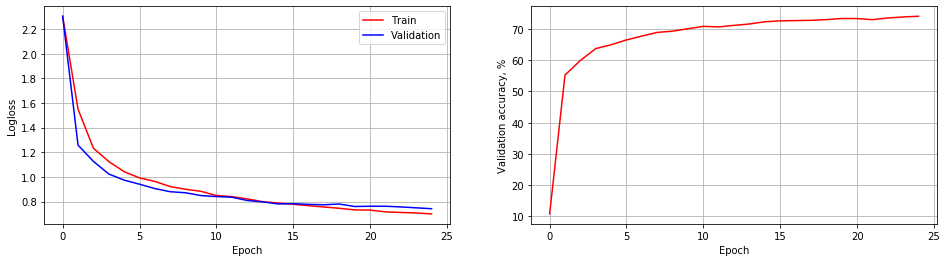

In [158]:
visualize_training(tr_loss[2], val_loss[2], val_acc[2])

#### Saving/loading model

In [19]:
#torch.save(model_torch2.state_dict(), os.path.join('.', 'model_torch2_weights'))
model_torch2.load_state_dict(torch.load(os.path.join('.', 'model_torch2_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Performance analysis

Test set accuracy: 73.9%


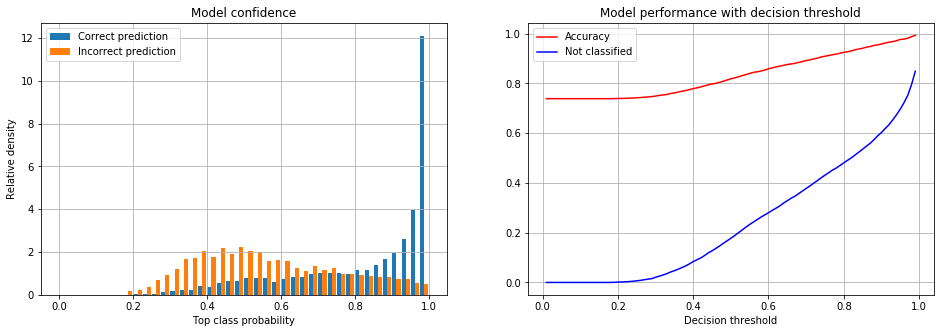

In [20]:
predX, gt, _ = predict_torch(model_torch2, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

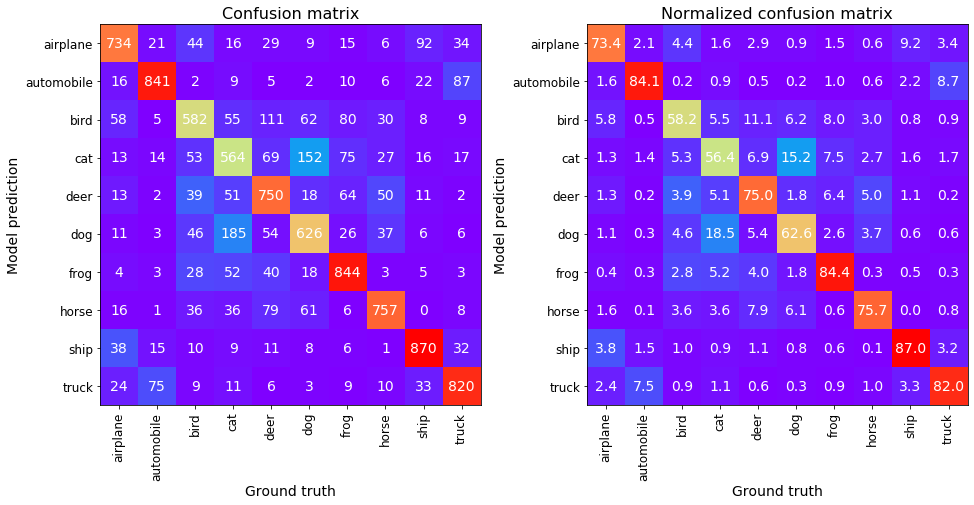

In [21]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

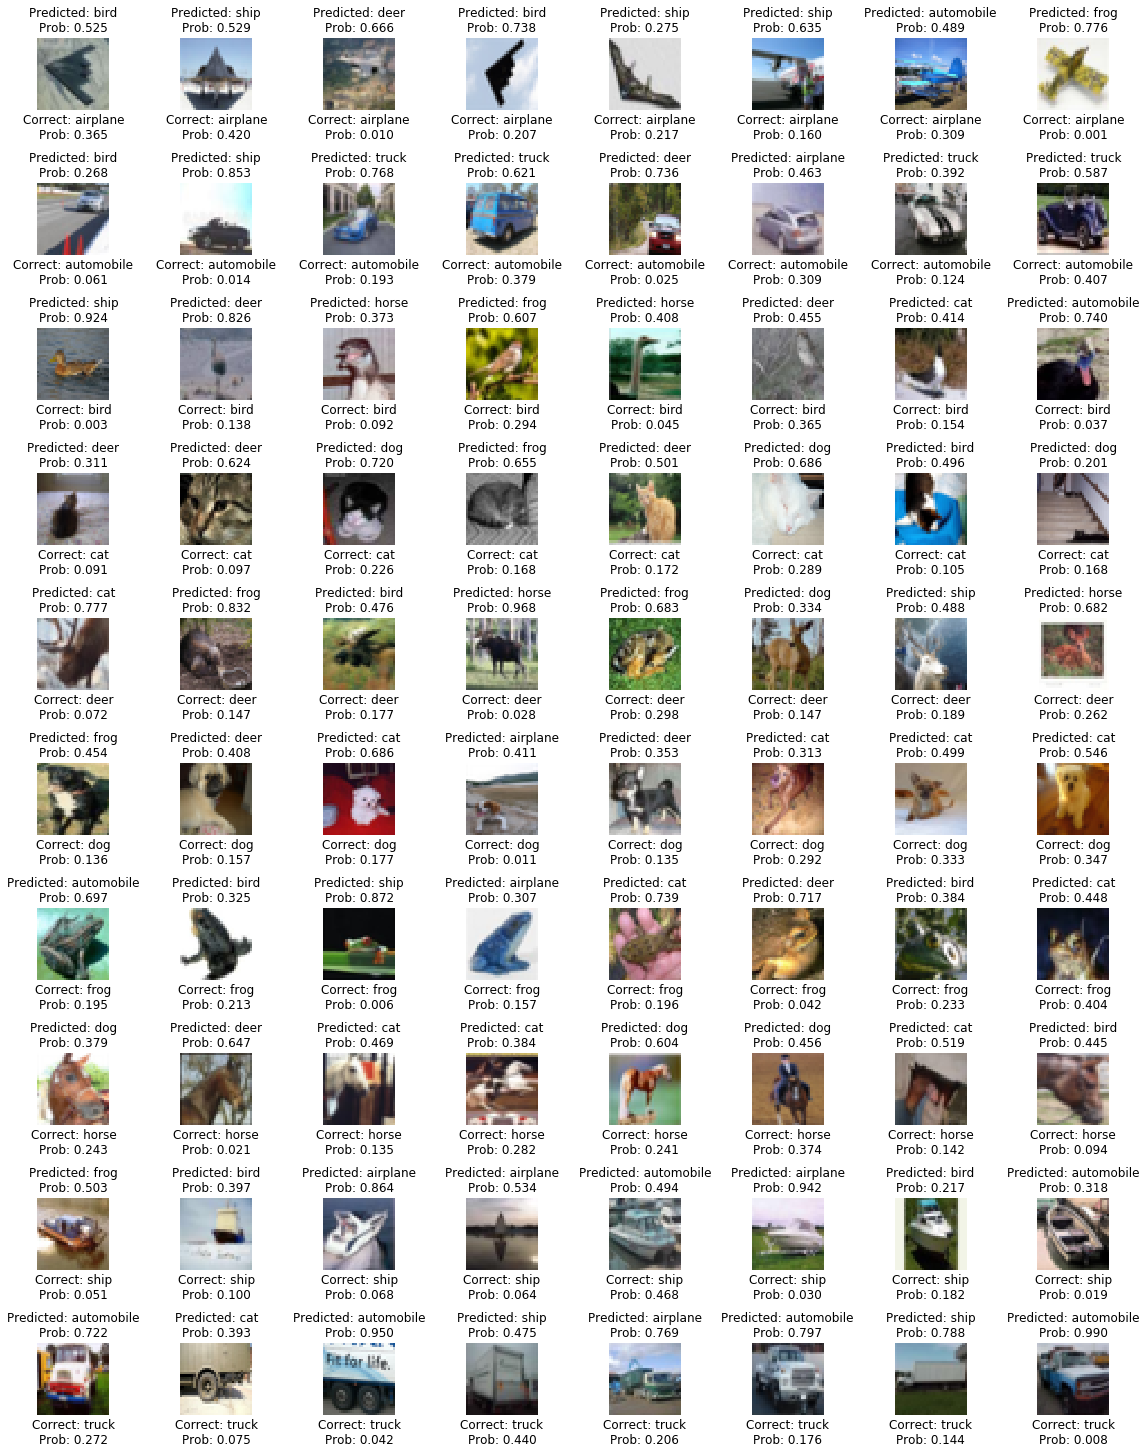

In [22]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 3.

In [9]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, kernel_size=3):
        super().__init__()
        
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, 
                      padding=(kernel_size - 1)//2, bias=False), 
            nn.BatchNorm2d(hidden_channels), 
            nn.ReLU(True), 
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(out_channels)
        )
        
        if in_channels == out_channels:
            self.walkaround = nn.BatchNorm2d(in_channels)
        else:
            self.walkaround = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), 
                nn.BatchNorm2d(out_channels)
            )
            
        self.relu_out = nn.ReLU(True)
        

    def forward(self, X):
        identity = self.walkaround(X)
        out = self.convblock(X)
        
        out += identity
        out = self.relu_out(out)
        
        return out

In [10]:
class TinyResNet(nn.Module):
    def __init__(self, res_blocks=1, res_kernel=3, downsampling='maxpool', 
                 start_channels=64, out_channels_mult=2, hid_channels_mult=1, 
                 drop_conv=None, drop_linear=None):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, start_channels, kernel_size=1, bias=False), 
            nn.BatchNorm2d(start_channels), 
            nn.ReLU(True)
        )
        
        # ----------------
        
        cur_sz = 32
        cur_channels = start_channels
        ib = 1
        
        while cur_sz > 1:
            self.add_module(f'resblock{ib}', nn.Sequential(
                Bottleneck(cur_channels, int(cur_channels*out_channels_mult), 
                           int(cur_channels*hid_channels_mult), res_kernel), 
                *[
                    Bottleneck(int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult), 
                               int(cur_channels*out_channels_mult*hid_channels_mult), 
                               res_kernel) for ix in range(res_blocks - 1)
                ]
            ))
            cur_channels = int(cur_channels*out_channels_mult)
            
            # --------------------------------
            
            if downsampling == 'maxpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.MaxPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'avgpool':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.AvgPool2d(kernel_size=2, stride=2), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            elif downsampling == 'conv':
                self.add_module(f'downsample{ib}', nn.Sequential(
                    nn.Conv2d(cur_channels, cur_channels, kernel_size=2, stride=2, bias=False), 
                    nn.BatchNorm2d(cur_channels), 
                    nn.ReLU(True)
                ))
            else:
                raise ValueError(f'Unknown downsampling code {downsampling}')
            cur_sz //= 2
            
            # --------------------------------
            
            if drop_conv:
                self.add_module(f'dropout{ib}', nn.Dropout(drop_conv))
            ib += 1
            
        # ----------------
        
        self.add_module('flattener', Flattener())
        features_mid = int(2**np.round(np.log2(10*cur_channels)/2))
                                
        if drop_linear:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Dropout(drop_linear), 
                nn.Linear(features_mid, 10)
            ))
        else:
            self.add_module('clf', nn.Sequential(
                nn.Linear(cur_channels, features_mid, bias=False), 
                nn.BatchNorm1d(features_mid), 
                nn.ReLU(True), 
                nn.Linear(features_mid, 10)
            ))

    def forward(self, X):
        out = X

        for xmodule in self.children():
            out = xmodule(out)

        return out

#### Optimizing

In [21]:
hp_torch3 = {
    'model': {
        'res_blocks': hp.choice('res_blocks', [1]), 
        'res_kernel': hp.choice('res_kernel', [3]), 
        'downsampling': hp.choice('downsampling', ['maxpool', 'avgpool', 'conv']),  
        'start_channels': hp.choice('start_channels', [16, 32, 48, 64]), 
        'out_channels_mult': hp.choice('out_channels_mult', [1.0, 1.5, 2.0]), 
        'hid_channels_mult': hp.quniform('hid_channels_mult', 0.25, 2.0, q=0.25), 
        'drop_conv': hp.choice('drop_conv', 
                               [None, hp.quniform('drop_conv_u', 0.05, 0.2, q=0.05)]), 
        'drop_linear': hp.choice('drop_linear', 
                                 [None, hp.quniform('drop_linear_u', 0.05, 0.5, q=0.05)])
    }, 
    'learning': {
        'lr': hp.loguniform('lr', -5.0*np.log(10), -2.0*np.log(10)), 
        'step': 1 + hp.randint('step', 5), 
        'gamma': hp.quniform('gamma', 0.1, 0.9, q=0.05), 
        'reg': hp.loguniform('reg', -5.0*np.log(10), -2.0*np.log(10)), 
    }
}

ho_sample(hp_torch3)

{'learning': {'gamma': 0.55,
  'lr': 0.0033323890371480492,
  'reg': 0.0004887726063422504,
  'step': 2},
 'model': {'downsampling': 'avgpool',
  'drop_conv': None,
  'drop_linear': 0.1,
  'hid_channels_mult': 0.5,
  'out_channels_mult': 2.0,
  'res_blocks': 1,
  'res_kernel': 3,
  'start_channels': 16}}

In [23]:
def f_min(hps):
    model = TinyResNet(**hps['model'])
    model.type(torch.cuda.FloatTensor)
    model.to(GPU)
    
    #init_check = initial_model_check(model, tiny_loader, tiny_loader, device=GPU, metric=accuracy)
    
    loss_fct = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), 
                           lr=hps['learning']['lr'], weight_decay=hps['learning']['reg'])
    lr_sch = torch.optim.lr_scheduler.StepLR(opt, 
                                             step_size=hps['learning']['step'], 
                                             gamma=hps['learning']['gamma'])
    
    tr_res = train_torch(model, GPU, train_loader, val_loader, 
                         loss_fct, opt, lr_sch, accuracy, 
                         num_epochs=18, verbose=False, show_progress=False, 
                         delay=20)
    
    code = hash(hps['learning']['lr'])
    torch.save(tr_res[-1], os.path.join('.', f'torch3_lr_{code}'))
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'loss': -max(tr_res[2]), 
        'status': STATUS_OK, 
        'tr_hist': tr_res[:-1]
    }

In [24]:
trls = Trials()

# Running optimization
ho_torch3 = fmin(f_min, space=hp_torch3, algo=tpe.suggest, 
                 trials=trls, max_evals=25, show_progressbar=True)

100%|██████████| 25/25 [6:33:21<00:00, 1016.27s/it, best loss: -0.84824] 


In [41]:
space_eval(hp_torch3, ho_torch3)

{'learning': {'gamma': 0.6000000000000001,
  'lr': 0.00048688838010866524,
  'reg': 0.0007036973475294802,
  'step': 4},
 'model': {'downsampling': 'maxpool',
  'drop_conv': 0.1,
  'drop_linear': None,
  'hid_channels_mult': 1.75,
  'out_channels_mult': 2.0,
  'res_blocks': 1,
  'res_kernel': 3,
  'start_channels': 48}}

#### Re-training model

In [154]:
model_torch3 = TinyResNet(start_channels=48, out_channels_mult=2.0, hid_channels_mult=1.75, 
                          drop_conv=0.1)
model_torch3.type(torch.cuda.FloatTensor)
model_torch3.to(GPU)

TinyResNet(
  (conv0): Sequential(
    (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (resblock1): Sequential(
    (0): Bottleneck(
      (convblock): Sequential(
        (0): Conv2d(48, 84, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(84, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(84, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (walkaround): Sequential(
        (0): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1)

In [155]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch3.parameters(), 
                       lr=5e-4, weight_decay=7e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.6)

tr_res = train_torch(model_torch3, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     early_stopping=True, early_stopping_rounds=4, 
                     num_epochs=24, delay=30)


--------------------------------
Epoch 1/24
--------------------------------


Training pass over.
Training loss: 1.4952069605255127
Validation loss: 1.1556155807876587
Validation metric: 0.59272
Delay for 30 seconds

--------------------------------
Epoch 2/24
--------------------------------


Training pass over.
Training loss: 1.0065329180335998
Validation loss: 0.9104289738082886
Validation metric: 0.68216
Delay for 30 seconds

--------------------------------
Epoch 3/24
--------------------------------


Training pass over.
Training loss: 0.7879825414339702
Validation loss: 0.7647913244438171
Validation metric: 0.73424
Delay for 30 seconds

--------------------------------
Epoch 4/24
--------------------------------


Training pass over.
Training loss: 0.6529658506075541
Validation loss: 0.6564956896591186
Validation metric: 0.77704
Delay for 30 seconds

--------------------------------
Epoch 5/24
--------------------------------


Training pass over.
Training loss: 0.4853643677266439
Validation loss: 0.6114084278869629
Validation metric: 0.78984
Delay for 30 seconds

--------------------------------
Epoch 6/24
--------------------------------


Training pass over.
Training loss: 0.4096332414627075
Validation loss: 0.5887374164581299
Validation metric: 0.80216
Delay for 30 seconds

--------------------------------
Epoch 7/24
--------------------------------


Training pass over.
Training loss: 0.35257748028437297
Validation loss: 0.5673282085037231
Validation metric: 0.81232
Delay for 30 seconds

--------------------------------
Epoch 8/24
--------------------------------


Training pass over.
Training loss: 0.30938159261862436
Validation loss: 0.5888111971473694
No improvement on validation for 1 epochs
Validation metric: 0.8068
Delay for 30 seconds

--------------------------------
Epoch 9/24
--------------------------------


Training pass over.
Training loss: 0.20198712832450866
Validation loss: 0.5347024990940094
Validation metric: 0.83104
Delay for 30 seconds

--------------------------------
Epoch 10/24
--------------------------------


Training pass over.
Training loss: 0.1564617231877645
Validation loss: 0.5355528606987
No improvement on validation for 1 epochs
Validation metric: 0.83072
Delay for 30 seconds

--------------------------------
Epoch 11/24
--------------------------------


Training pass over.
Training loss: 0.13023917497316997
Validation loss: 0.5853343867111206
No improvement on validation for 2 epochs
Validation metric: 0.82104
Delay for 30 seconds

--------------------------------
Epoch 12/24
--------------------------------


Training pass over.
Training loss: 0.11615712708632152
Validation loss: 0.5715817570877075
No improvement on validation for 3 epochs
Validation metric: 0.82872
Delay for 30 seconds

--------------------------------
Epoch 13/24
--------------------------------


Training pass over.
Training loss: 0.07744976758519809
Validation loss: 0.5623361760520935
No improvement on validation for 4 epochs
Invoking early stopping
Validation metric: 0.83456


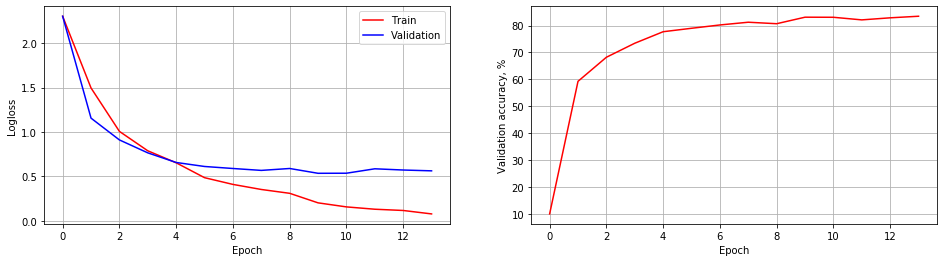

In [156]:
visualize_training([np.log(10)] + tr_res[0], [np.log(10)] + tr_res[1], [0.1] + tr_res[2])

#### Saving/loading model

In [158]:
torch.save(model_torch3.state_dict(), os.path.join('.', 'TinyResNet3_weights'))
#model_torch3.load_state_dict(torch.load(os.path.join('.', 'model_torch3_weights')))

#### Analyzing performance

Test set accuracy: 82.7%


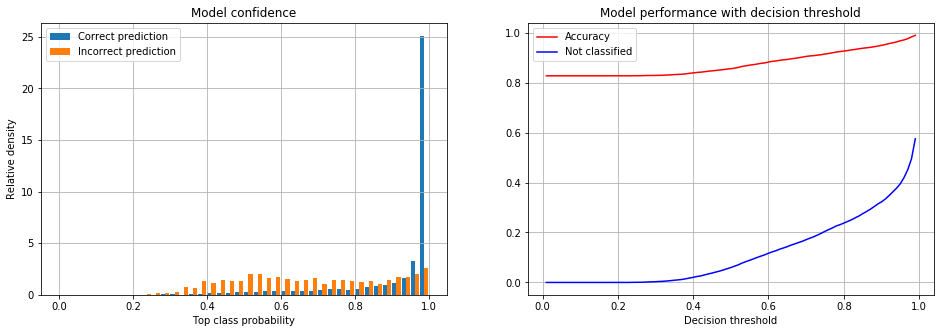

In [159]:
predX, gt, _ = predict_torch(model_torch3, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

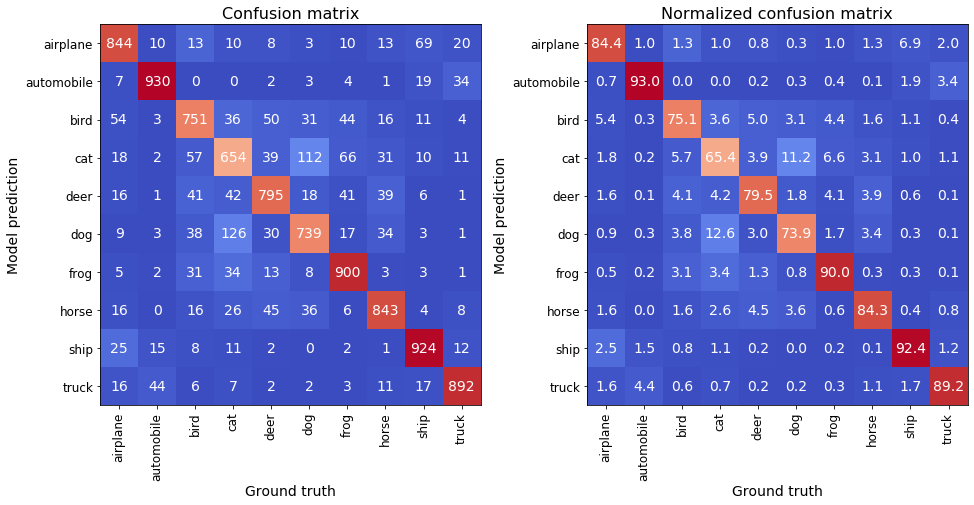

In [160]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories, 'coolwarm', 'white')

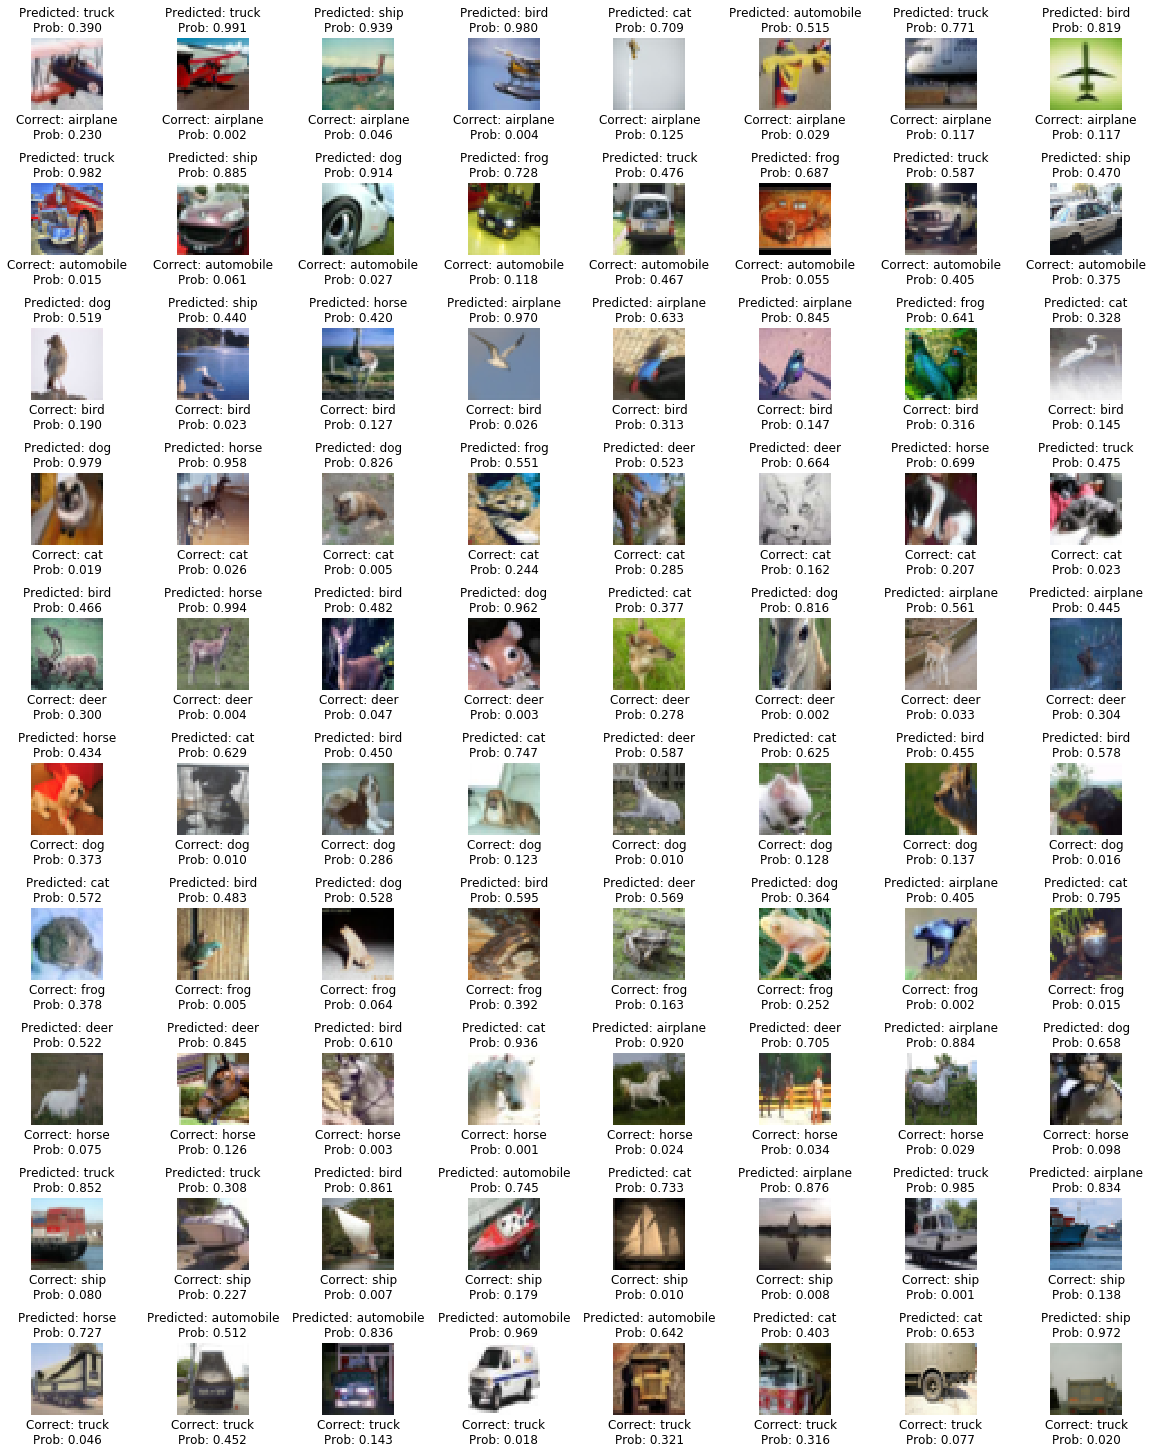

In [161]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 4.

In [11]:
from albumentations import Compose, OneOf, Blur, Flip, Rotate, HueSaturationValue, Normalize
from albumentations.pytorch import ToTensor

In [12]:
class AugmentedCIFAR10(Dataset):
    def __init__(self, X, y, transformation=None):
        self.X = X
        self.y = y
        self.transformation = transformation
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, ix):
        img = self.X[ix]
        
        if self.transformation:
            img = self.transformation(image=img)['image']
            
        return (torch.from_numpy(img), self.y[ix])

In [13]:
train_dset_aug = AugmentedCIFAR10(X_train0[train_idxs], y_train0[train_idxs], Compose([
    Blur(blur_limit=3, p=0.1), 
    OneOf([
        Flip(p=0.5), Rotate(limit=20, p=0.5), 
    ]), 
    Flip(p=0.3), 
    Rotate(limit=20, p=0.3), 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
]))

val_dset_aug = AugmentedCIFAR10(X_train0[val_idxs], y_train0[val_idxs], 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

test_dset_aug = AugmentedCIFAR10(X_test0, y_test0, 
    Normalize(mean=X_mean[:, None, None], std=X_std[:, None, None]), 
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

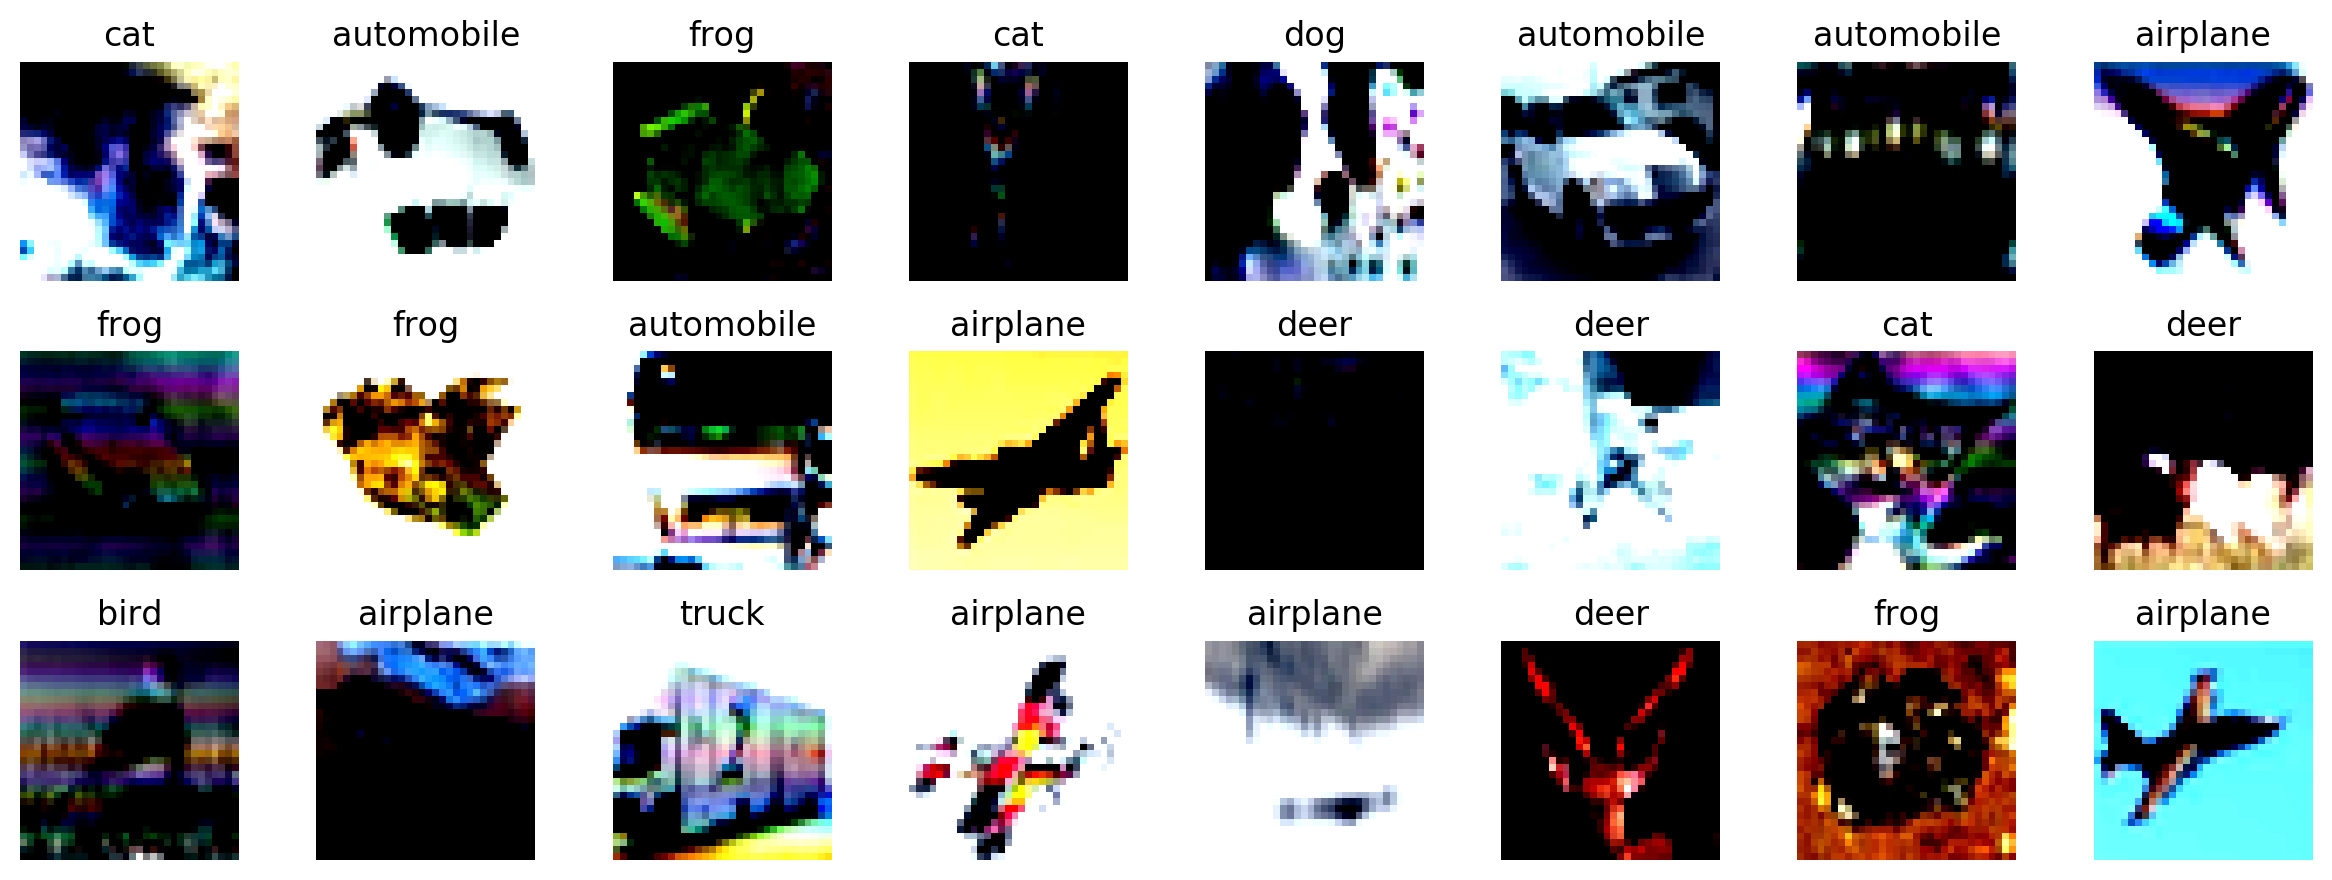

In [14]:
n_imgs = 24
n_per_row = 8
n_rows = int(np.ceil(n_imgs/n_per_row))

fig0, axs = plt.subplots(nrows=n_rows, ncols=n_per_row, 
                         figsize=(1.5*n_per_row, 1.5*n_rows), dpi=200)
idxs = np.random.choice(np.arange(len(train_dset_aug)), n_imgs, replace=False).reshape(n_rows, -1)

for (xidxs, xaxs) in zip(idxs, axs):
    for (xidx, xax) in zip(xidxs, xaxs):
        ximg, xlabel = train_dset_aug[xidx]
        xax.imshow(ximg.numpy().transpose((1, 2, 0)))
        xax.set_title(categories[xlabel])
        xax.axis('off')
        
plt.tight_layout()

In [18]:
train_loader_aug = DataLoader(train_dset_aug, batch_size=96, 
                              sampler=RandomSampler(train_dset_aug))
val_loader_aug = DataLoader(val_dset_aug, batch_size=96, 
                            sampler=SequentialSampler(val_dset_aug))
test_loader_aug = DataLoader(test_dset_aug, batch_size=96, 
                             sampler=SequentialSampler(test_dset_aug))

#### Training

In [19]:
hp_torch4 = {
    'model': {
        'res_blocks': 1, 
        'res_kernel': 3, 
        'downsampling': hp.choice('downsampling', ['maxpool', 'conv']),  
        'start_channels': hp.choice('start_channels', [16, 32, 48, 64]), 
        'out_channels_mult': hp.choice('out_channels_mult', [1.0, 1.5, 2.0]), 
        'hid_channels_mult': hp.quniform('hid_channels_mult', 1.0, 2.0, q=0.25), 
        'drop_conv': 0.1, 
        'drop_linear': None
    }, 
    'learning': {
        'lr_sch': hp.choice('lr_sch', [
            {
                'type': 'step_lr', 
                'pars': {
                    'step_size': 2 + hp.randint('s.step', 4), 
                    'gamma': hp.quniform('s.gamma', 0.3, 0.8, q=0.05), 
                }
            }, 
            {
                'type': 'cosine', 
                'pars': {
                    'T_max': hp.choice('c.T_max', [3, 4, 6, 8]), 
                    'eta_min': hp.loguniform('c.eta_min', -6.0*np.log(10), -5.0*np.log(10)), 
                }
            }, 
            {
                'type': 'plateau', 
                'pars': {
                    'factor': hp.quniform('p.gamma', 0.2, 0.8, q=0.05), 
                    'patience': hp.choice('p.patience', [2, 3, 4, 5]), 
                }
            }
        ]), 
        'opt': {
            'lr': hp.loguniform('lr', -4.0*np.log(10), -3.0*np.log(10)), 
            'weight_decay': hp.loguniform('reg', -4.0*np.log(10), -3.0*np.log(10))
        }
    }
}

ho_sample(hp_torch4)['learning']['lr_sch']

{'pars': {'gamma': 0.35000000000000003, 'step_size': 4}, 'type': 'step_lr'}

In [20]:
def f_min(hps):
    model = TinyResNet(**hps['model'])
    model.type(torch.cuda.FloatTensor)
    model.to(GPU)
    
    #init_check = initial_model_check(model, tiny_loader, tiny_loader, device=GPU, metric=accuracy)
    
    loss_fct = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), **hps['learning']['opt'])
    
    if hps['learning']['lr_sch']['type'] == 'step_lr':
        lr_sch = torch.optim.lr_scheduler.StepLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'cosine':
        lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 
            **hps['learning']['lr_sch']['pars'])
    elif hps['learning']['lr_sch']['type'] == 'plateau':
        lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 
            **hps['learning']['lr_sch']['pars'])
    
    tr_res = train_torch(model, GPU, train_loader_aug, val_loader_aug, 
                         loss_fct, opt, lr_sch, accuracy, 
                         num_epochs=18, verbose=False, show_progress=False, 
                         early_stopping=(hps['learning']['lr_sch']['type'] == 'step_lr'), 
                         early_stopping_rounds=3, 
                         lr_plateau=(hps['learning']['lr_sch']['type'] == 'plateau'), 
                         delay=25)
    
    code = hash(hps['learning']['opt']['lr'])
    torch.save(tr_res[-1], os.path.join('.', f'torch4_lr_{code}'))
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'loss': -max(tr_res[2]), 
        'status': STATUS_OK, 
        'tr_hist': tr_res[:-1], 
        'hash_code': code
    }

In [24]:
# trls = Trials()

# Running optimization
ho_torch4 = fmin(f_min, space=hp_torch4, algo=tpe.suggest, 
                 trials=trls, max_evals=25, show_progressbar=True)

  5%|▌         | 1/19 [27:40<8:18:12, 1660.72s/it, best loss: -0.78264]


KeyboardInterrupt: 

In [69]:
# with open(os.path.join('.', 'trls4'), 'wb') as fh:
#     pickle.dump(trls, fh)

In [21]:
with open(os.path.join('.', 'trls4'), 'rb') as fh:
    trls = pickle.load(fh)